## Movielens

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [2]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [5]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [9]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

In [10]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [8]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2, use_wd_sched=True)

A Jupyter Widget

[ 0.       0.81709  0.80992]                                    
[ 1.       0.77104  0.78133]                                    
[ 2.       0.60526  0.76716]                                    



Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [51]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [52]:
preds = learn.predict()

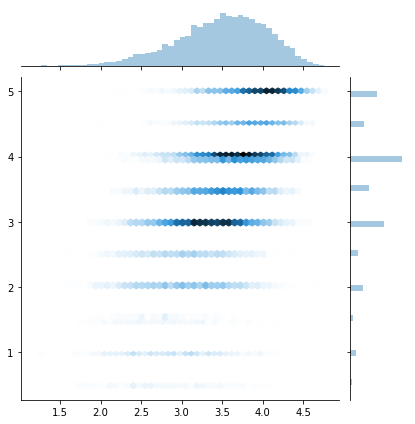

In [56]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [79]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [80]:
m=learn.model; m

EmbeddingDotBias (
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [81]:
movie_bias = to_np(m.ib(V(topMovieIdx)))

In [82]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [83]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.96070349, 'Battlefield Earth (2000)'),
 (-0.76858485, 'Speed 2: Cruise Control (1997)'),
 (-0.73675376, 'Wild Wild West (1999)'),
 (-0.73655486, 'Anaconda (1997)'),
 (-0.72457194, 'Super Mario Bros. (1993)'),
 (-0.69564718, 'Congo (1995)'),
 (-0.67043746, 'Superman III (1983)'),
 (-0.64385736, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.62750411, "Joe's Apartment (1996)"),
 (-0.60154277, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.59929478, 'Batman & Robin (1997)'),
 (-0.59667748, 'Jaws 3-D (1983)'),
 (-0.5921765, 'Dungeons & Dragons (2000)'),
 (-0.59074384, 'Inspector Gadget (1999)'),
 (-0.57559621, 'Haunting, The (1999)')]

In [84]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.96070349, 'Battlefield Earth (2000)'),
 (-0.76858485, 'Speed 2: Cruise Control (1997)'),
 (-0.73675376, 'Wild Wild West (1999)'),
 (-0.73655486, 'Anaconda (1997)'),
 (-0.72457194, 'Super Mario Bros. (1993)'),
 (-0.69564718, 'Congo (1995)'),
 (-0.67043746, 'Superman III (1983)'),
 (-0.64385736, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.62750411, "Joe's Apartment (1996)"),
 (-0.60154277, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.59929478, 'Batman & Robin (1997)'),
 (-0.59667748, 'Jaws 3-D (1983)'),
 (-0.5921765, 'Dungeons & Dragons (2000)'),
 (-0.59074384, 'Inspector Gadget (1999)'),
 (-0.57559621, 'Haunting, The (1999)')]

In [85]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3070084, 'Shawshank Redemption, The (1994)'),
 (1.1196285, 'Godfather, The (1972)'),
 (1.0844109, 'Usual Suspects, The (1995)'),
 (0.96578616, "Schindler's List (1993)"),
 (0.90921378, 'Silence of the Lambs, The (1991)'),
 (0.89407367, 'Godfather: Part II, The (1974)'),
 (0.87860429, '12 Angry Men (1957)'),
 (0.87099487, 'Pulp Fiction (1994)'),
 (0.85731125, 'Memento (2000)'),
 (0.85192037, 'Matrix, The (1999)'),
 (0.84797066, 'Dark Knight, The (2008)'),
 (0.8479442, 'To Kill a Mockingbird (1962)'),
 (0.83670187, 'Forrest Gump (1994)'),
 (0.8192088, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.81887919, 'Rear Window (1954)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [86]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [87]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [88]:
movie_pca.shape

(3, 3000)

In [89]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [90]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06748189, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.061572548, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.061050549, 'Waterworld (1995)'),
 (0.057877172, 'Rocky V (1990)'),
 (0.057183612, 'Home Alone 3 (1997)'),
 (0.056849808, 'Armageddon (1998)'),
 (0.056735475, 'Miss Congeniality (2000)'),
 (0.054530937, 'Outbreak (1995)'),
 (0.053475372, 'Evolution (2001)'),
 (0.052995622, 'Pay It Forward (2000)')]

In [91]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.078433245, 'Godfather: Part II, The (1974)'),
 (-0.072180331, 'Fargo (1996)'),
 (-0.071351372, 'Pulp Fiction (1994)'),
 (-0.068537779, 'Goodfellas (1990)'),
 (-0.067418814, 'Chinatown (1974)'),
 (-0.066787124, 'Taxi Driver (1976)'),
 (-0.06392362, 'Apocalypse Now (1979)'),
 (-0.060093477, 'Brokeback Mountain (2005)'),
 (-0.057078246, 'Godfather, The (1972)'),
 (-0.055729419, 'Player, The (1992)')]

In [92]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [93]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.058975246, 'Bonfire of the Vanities (1990)'),
 (0.055992026, '2001: A Space Odyssey (1968)'),
 (0.054682467, 'Tank Girl (1995)'),
 (0.054429606, 'Purple Rose of Cairo, The (1985)'),
 (0.050998077, 'Mulholland Drive (2001)'),
 (0.049576689, "Joe's Apartment (1996)"),
 (0.047549088, 'What Ever Happened to Baby Jane? (1962)'),
 (0.046446536, 'Island of Dr. Moreau, The (1996)'),
 (0.045140576, 'L.A. Story (1991)'),
 (0.045048587, 'Mouse Hunt (1997)')]

In [94]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.1064609, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.090635143, 'Aladdin (1992)'),
 (-0.089208141, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.088854566, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.085997969, 'Beauty and the Beast (1991)'),
 (-0.085541978, "Schindler's List (1993)"),
 (-0.080922142, 'Saving Private Ryan (1998)'),
 (-0.079378694,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.079295151, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.078875825, 'My Big Fat Greek Wedding (2002)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

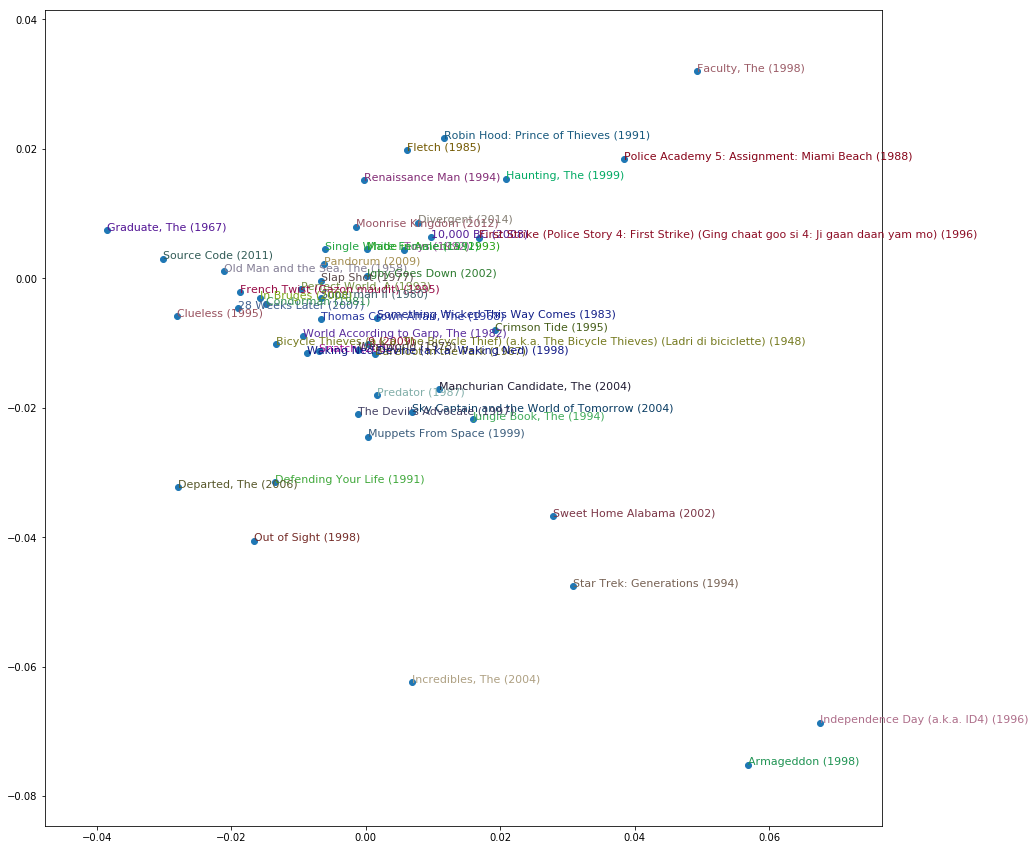

In [97]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [98]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [99]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [100]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [101]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [102]:
model=DotProduct()

In [103]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [11]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [12]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [13]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [14]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [15]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [16]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.      1.6368  1.6415]                                      
[ 1.       1.13749  1.29373]                                   
[ 2.       0.89736  1.22818]                                    



In [13]:
set_lrs(opt, 0.01)

In [14]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.69763  1.14979]                                    
[ 1.       0.70115  1.13657]                                    
[ 2.       0.66739  1.1303 ]                                    



### Bias

In [17]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [18]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [19]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [20]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88212  0.83626]                                    
[ 1.       0.8108   0.81831]                                    
[ 2.       0.78864  0.80989]                                    



In [47]:
set_lrs(opt, 1e-2)

In [48]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.72795  0.80337]                                    
[ 1.       0.75064  0.80203]                                    
[ 2.       0.75122  0.80124]                                    



### Mini net

In [49]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [54]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [51]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88043  0.82363]                                    
[ 1.       0.8941   0.81264]                                    
[ 2.       0.86179  0.80706]                                    



In [52]:
set_lrs(opt, 1e-3)

In [53]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.7669   0.78622]                                    
[ 1.       0.74277  0.78152]                                    
[ 2.       0.69891  0.78075]                                    

